In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os
import math
from PIL import Image
from data_utils import *
from network_utils import *

In [5]:
train_image_dir = 'F:\Sample\Train'
test_image_dir = 'F:\Sample\Test'
image_height, image_width = 128, 128
num_classes = 80
num_channels = 3
learning_rate = 0.001
keep_prob = 0.5
num_epochs = 1000
minibatch_size = 256

In [6]:
train_json_path = 'F:\Sample\scene_train_annotations.json'
train_label = convert_json(train_json_path)
X_train_orig, Y_train_orig = dataset(train_image_dir, train_label, image_height, image_width)

test_json_path = 'F:\Sample\scene_test_annotations.json'
test_label = convert_json(test_json_path)  
X_test_orig, Y_test_orig = dataset(test_image_dir, test_label, image_height, image_width)

In [7]:
X_train = X_train_orig / 255.
num_train_examples = X_train.shape[0]
Y_train = np.eye(80)[Y_train_orig.reshape(-1)]    #convert to one hot
print('X_train.shape: ' + str(X_train.shape))
print('Y_train.shape: ' + str(Y_train.shape))

X_test = X_test_orig / 255.
num_test_examples = X_test.shape[0]
Y_test = np.eye(80)[Y_test_orig.reshape(-1)]    #convert to one hot
print('X_test.shape: ' + str(X_test.shape))
print('Y_test.shape: ' + str(Y_test.shape))

X_train.shape: (40, 128, 128, 3)
Y_train.shape: (40, 80)
X_test.shape: (30, 128, 128, 3)
Y_test.shape: (30, 80)


In [27]:
def model(X_train, Y_train, learning_rate, keep_prob, num_epochs, minibatch_size, print_cost=True):
    
    tf.reset_default_graph()
    #tf.set_random_seed(1)

    # Initialize parameters and Create Placeholders
    parameters = get_parameters()
    X = tf.placeholder(tf.float32, [None, image_height, image_width, num_channels])
    Y = tf.placeholder(tf.float32, [None, num_classes])

    # Forward propagation, Cost function, Backward propagation
    Z = forward_propagation(X, parameters, keep_prob)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    #seed = 2
    costs = []

    with tf.Session() as sess:
        
        saver = tf.train.Saver(max_to_keep = 3)
        #min_cost = 1.e6
        
        cheakpoint = tf.train.get_checkpoint_state('./cheakpoint/')
        if cheakpoint and cheakpoint.model_checkpoint_path:
            print('Restore the model from checkpoint %s' % cheakpoint.model_checkpoint_path)
            # Restores from checkpoint
            saver.restore(sess, cheakpoint.model_checkpoint_path)
            start = int(cheakpoint.model_checkpoint_path.split('/')[-1].split('-')[-1])
        else:
            sess.run(init)
            start = 0
            print('start training from new state')                  
        
        for epoch in range(start, start + num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(num_train_examples / minibatch_size)
            #seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 200 == 0:
                print('Cost after epoch %i: %f' %(epoch, minibatch_cost))
                
            costs.append(minibatch_cost)
            """
            if minibatch_cost < min_cost:
                min_cost = minibatch
                #store the model with the minimum cost
                saver.save(sess, './cheakpoint/model.ckpt', global_step = epoch)
            """    
            if epoch % 200 == 0:
                saver.save(sess, './cheakpoint/model.ckpt', global_step = epoch)
                print('writing checkpoint at step %s' % epoch)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
        
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Test Accuracy:", test_accuracy)
        
    return parameters, train_accuracy, test_accuracy

Restore the model from checkpoint ./cheakpoint/model.ckpt-45
INFO:tensorflow:Restoring parameters from ./cheakpoint/model.ckpt-45
Cost after epoch 45: 0.464075
writing checkpoint at step 45


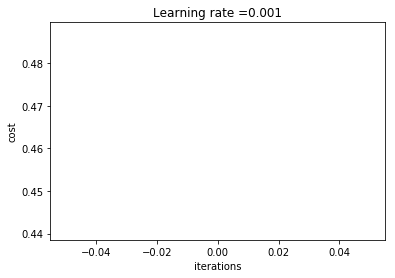

Train Accuracy: 0.9
Test Accuracy: 0.0


In [28]:
parameters, _, _ = model(X_train, Y_train, learning_rate, keep_prob, num_epochs, minibatch_size)